<center> <h1>  Assignment 9 -  week 14 </h1> </center>
<center> <h3> George Adamov </h3> </center>
<center> <h3> CoLab Username: zito </h3> </center>

## 1. Reinforcement Learning for the Taxi Problem

Taxi Environment: Taxi-v2 is a task introduced to illustrate some issues in hierarchical reinforcement learning. There are 4 locations (labeled by different letters) and your job is to pick up the passenger at one location and drop him off in another. You receive +20 points for a successful dropoff, and lose 1 point for every timestep it takes. There is also a 10 point penalty for illegal pick-up and drop-off actions. The figure below illustrates the environment:  

    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
        
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east 
    - 3: move west 
    - 4: pickup passenger
    - 5: dropoff passenger
    
    Rewards: 
    There is a reward of -1 for each action and an additional reward of +20 for delivering the passenger. There is a reward of -10 for executing actions "pickup" and "dropoff" illegally.
    
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)


In [0]:
# first install the rl module and restart the restart the kernel
!pip install keras-rl

In [0]:

import os
import sys
import gym # openAi gym
from gym import envs
import datetime
import keras 
import seaborn as sns
import random
import time
import pandas as pd 
import numpy as np
from time import sleep



import tensorflow as tf
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
import warnings

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals



# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

from IPython.display import display
from IPython.display import clear_output
warnings.filterwarnings('ignore')





Using TensorFlow backend.


In [0]:
env = gym.make('Taxi-v3')
obs = env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [0]:
# six actions and 500 states total
print(env.action_space)
print(env.observation_space.n)

Discrete(6)
500


In [0]:
# moving the actor
print(env.step(action=5)) 
env.render()

(85, 20, True, {'prob': 1.0})
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)


In [0]:
# check possibilities of the current state
env.env.P[97]  

{0: [(1.0, 197, -1, False)],
 1: [(1.0, 97, -1, False)],
 2: [(1.0, 97, -1, False)],
 3: [(1.0, 77, -1, False)],
 4: [(1.0, 97, -10, False)],
 5: [(1.0, 85, 20, True)]}

###  1.1. Random Search

In [0]:

random_policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA
def random_policy_steps_count():
    state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(env.action_space.sample())  
        counter += 1
    return counter

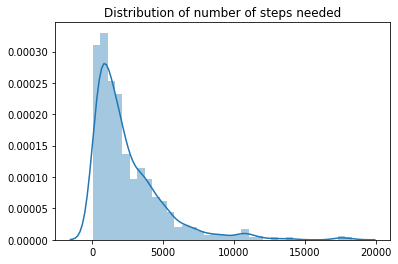

In [0]:
counts = [random_policy_steps_count() for i in range(1000)]
sns.distplot(counts)
plt.title("Distribution of number of steps needed")
plt.show()

In [0]:
print("An agent using Random search takes about an average of ", 
      str(int(np.mean(counts))), 
      " steps to successfully complete its mission.")

An agent using Random search takes about an average of  2515  steps to successfully complete its mission.


### 1.2 Value Iteration

In [0]:
# Value iterated policy improvement

def policy_eval(policy, env, discount_factor=1.0, theta=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(env.env.nS)
    while True:
        # TODO: Implement!
        delta = 0  #delta = change in value of state from one iteration to next
       
        for state in range(env.env.nS):  #for all states
            val = 0  #initiate value as 0
            
            for action,act_prob in enumerate(policy[state]): #for all actions/action probabilities
                for prob,next_state,reward,done in env.env.P[state][action]:  #transition probabilities,state,rewards of each action
                    val += act_prob * prob * (reward + discount_factor * V[next_state])  #eqn to calculate
            delta = max(delta, np.abs(val-V[state]))
            V[state] = val
        if delta < theta:  #break if the change in value is less than the threshold (theta)
            break
    return np.array(V)

# -----------------------------------------------------

def value_iteration(env, theta=0.0001, discount_factor=1.0):
    """
    Value Iteration Algorithm.
    
    Args:
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a list of transition tuples (prob, next_state, reward, done).
            env.nS is a number of states in the environment. 
            env.nA is a number of actions in the environment.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: Gamma discount factor.
        
    Returns:
        A tuple (policy, V) of the optimal policy and the optimal value function.        
    """
    
    def one_step_lookahead(state, V):
        """
        Helper function to calculate the value for all action in a given state.
        
        Args:
            state: The state to consider (int)
            V: The value to use as an estimator, Vector of length env.nS
        
        Returns:
            A vector of length env.nA containing the expected value of each action.
        """
        A = np.zeros(env.env.nA)
        for act in range(env.env.nA):
            for prob, next_state, reward, done in env.env.P[state][act]:
                A[act] += prob * (reward + discount_factor*V[next_state])
        return A
    
    V = np.zeros(env.env.nS)
    while True:
        delta = 0  #checker for improvements across states
        for state in range(env.env.nS):
            act_values = one_step_lookahead(state,V)  #lookahead one step
            best_act_value = np.max(act_values) #get best action value
            delta = max(delta,np.abs(best_act_value - V[state]))  #find max delta across all states
            V[state] = best_act_value  #update value to best action value
        if delta < theta:  #if max improvement less than threshold
            break
    policy = np.zeros([env.env.nS, env.env.nA])
    for state in range(env.env.nS):  #for all states, create deterministic policy
        act_val = one_step_lookahead(state,V)
        best_action = np.argmax(act_val)
        policy[state][best_action] = 1
        
    
    # Implement!
    return policy, V

In [0]:
# Next, we use value iteration to improve our policy.

val_iter_policy = value_iteration(env,discount_factor=0.99)
val_iter_policy[0]

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [0]:
def count(policy):
    curr_state = env.reset()
    counter = 0
    reward = None
    while reward != 20:
        state, reward, done, info = env.step(np.argmax(policy[curr_state]))  
        curr_state = state
        counter += 1
    return counter

An agent using a policy which has been value-iterated takes about an average of 13 steps to successfully complete its mission.


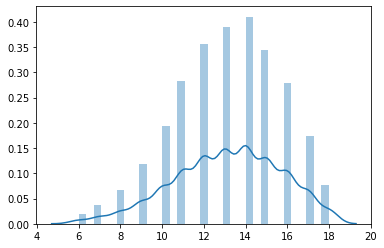

In [0]:
val_count = count(val_iter_policy[0])
val_counts = [count(val_iter_policy[0]) for i in range(10000)]
print("An agent using a policy which has been value-iterated takes about an average of " + str(int(np.mean(val_counts)))
      + " steps to successfully complete its mission.")
sns.distplot(val_counts)
plt.show()

### 1.3 Q-learning

In [0]:
# Q-learning with epsilon-greedy method

def Q_learning_train(env,alpha,gamma,epsilon,episodes): 
    """Q Learning Algorithm with epsilon greedy 

    Args:
        env: Environment 
        alpha: Learning Rate --> Extent to which our Q-values are being updated in every iteration.
        gamma: Discount Rate --> How much importance we want to give to future rewards
        epsilon: Probability of selecting random action instead of the 'optimal' action
        episodes: No. of episodes to train on

    Returns:
        Q-learning Trained policy

    """
    %%time
    """Training the agent"""

    # For plotting metrics
    all_epochs = []
    all_penalties = []
    
    #Initialize Q table of 500 x 6 size (500 states and 6 actions) with all zeroes
    q_table = np.zeros([env.observation_space.n, env.action_space.n])  
    
    for i in range(1, episodes+1):
        state = env.reset()

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space randomly
            else:
                action = np.argmax(q_table[state]) # Exploit learned values by choosing optimal values

            next_state, reward, done, info = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state
            epochs += 1

        if i % 100 == 0:
            clear_output(wait=True)
            print(f"Episode: {i}")
    # Start with a random policy
    policy = np.ones([env.env.nS, env.env.nA]) / env.env.nA

    for state in range(env.env.nS):  #for each states
        best_act = np.argmax(q_table[state]) #find best action
        policy[state] = np.eye(env.env.nA)[best_act]  #update 
        
    print("Training finished.\n")
    return policy, q_table

In [0]:
env.reset()
Q_learn_pol = Q_learning_train(env,0.2,0.95,0.1,100000)

Episode: 100000
Training finished.



An agent using a policy which has been improved using Q-learning takes about an average of  13  steps to successfully complete its mission.


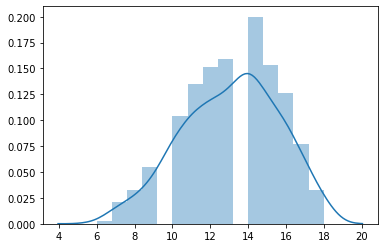

In [0]:
Q_Learning_counts = count(Q_learn_pol[0])
Q_counts = [count(Q_learn_pol[0]) for i in range(1000)]
print("An agent using a policy which has been improved using Q-learning takes about an average of ", 
      str(int(np.mean(Q_counts))), " steps to successfully complete its mission.")
sns.distplot(Q_counts)
plt.show()

In [0]:
# view animation of how optimal policies work


def view_policy_anim(policy):
    penalties, reward = 0, 0

    frames = [] # for animation

    done = False
    curr_state = env.reset()
    while not done:
        action = np.argmax(policy[0][curr_state])
        state, reward, done, info = env.step(action)
        curr_state = state
        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'fr': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
    def print_frames(frames):
        for i, frame in enumerate(frames):
            clear_output(wait=True)
            print(frame['fr'])
            time.sleep(1)
            print(f"Timestep: {i + 1}")
            print(f"State: {frame['state']}")
            print(f"Action: {frame['action']}")
            print(f"Reward: {frame['reward']}")
            sleep(.2)

    print_frames(frames)
    print('Voala !')

In [0]:
view_policy_anim(val_iter_policy)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 14
State: 475
Action: 5
Reward: 20
Voala !


In [0]:
view_policy_anim(Q_learn_pol)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)

Timestep: 13
State: 475
Action: 5
Reward: 20
Voala !


## 2. Q-Learning  

In this experiment I implement a Q-Learning strategy for the Cart-Pole problem. I use code snippets from the book of Aurelen Geron - "Hands-on machine learning with Scikit-Learn and TensorFlow", 2017, Chapter 16. 

Restart the kernel before runnning the code below


In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    !pip install -q -U tf-agents-nightly pyvirtualdisplay gym[atari]
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [0]:
# if > 0.2.1 uninstall this package
pyvirtualdisplay.__version__

'0.2.5'

In [0]:
!pip uninstall pyvirtualdisplay

In [0]:
# downgrade the version of this package
# otherwhise colab will not render
!pip install pyvirtualdisplay==0.2.1

In [0]:
## if needed 
# !apt install -y xvfb

In [0]:
import pyvirtualdisplay
import gym

In [0]:
pyvirtualdisplay.__version__

'0.2.1'

In [0]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [0]:
env = gym.make('CartPole-v1')
env.seed(42)
obs = env.reset()

/usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [0]:
env.render()

True

In [0]:
img = env.render(mode="rgb_array")
img.shape

(400, 600, 3)

In [0]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img

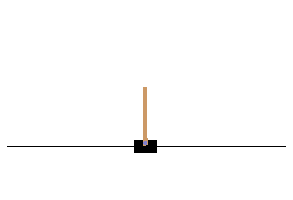

In [0]:
plot_environment(env)
plt.show()

In [0]:
save_fig("cart_pole_plot")

Saving figure cart_pole_plot


<Figure size 432x288 with 0 Axes>

In [0]:
# define some transition probabilities, rewards and possible actions.
# in state s0, if action a0 is chosen then with proba 0.7 we will go to state s0 with reward +10, with probability 0.3 we will go to state s1 with no reward 
#  never go to state s2 (so the transition probabilities are [0.7, 0.3, 0.0], and the rewards are [+10, 0, 0])

transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [0]:
# Q-Value Iteration

Q_values = np.full((3, 3), -np.inf) # -np.inf for impossible actions
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # for all possible actions

gamma = 0.90  # the discount factor

history1 = [] # Not shown in the book (for the figure below)
for iteration in range(100):
    Q_prev = Q_values.copy()
    history1.append(Q_prev) # Not shown
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                for sp in range(3)])

history1 = np.array(history1) # Not shown




In [0]:
# Q-Learning

# a function to perform some action and get the new state and a reward

def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

In [0]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [0]:
np.random.seed(42)

Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0

alpha0 = 0.05 # initial learning rate
decay = 0.005 # learning rate decay
gamma = 0.90 # discount factor
state = 0 # initial state
history2 = [] # Not shown in the book

for iteration in range(20000):
    history2.append(Q_values.copy()) # Not shown
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = np.max(Q_values[next_state]) # greedy policy at the next step
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # Not shown

Saving figure q_value_plot_comparison


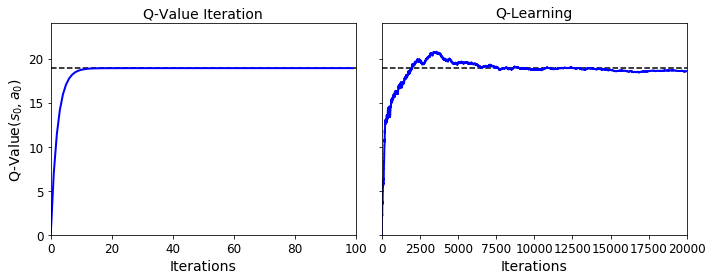

In [0]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (100, 20000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])

save_fig("q_value_plot_comparison")